<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from node2vec import Node2Vec
from node2vec.edges import HadamardEmbedder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition, datasets
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import os

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
def get_dirs():
    dirs = []
    for i in os.listdir('./data/'):
        if os.path.isdir('./data/{}'.format(i)):
            dirs.append(i)
    return dirs


def get_data(name,sep=','):
    df = pd.DataFrame()
    for x in get_dirs():
        path = "./data/{}/{}{}".format(x, x, name)
        temp = pd.read_csv(path,sep=sep)
        df = df.append(temp)
    return df

In [3]:
emb_df = get_data('emb.csv.zip')
emb_df = emb_df.drop(columns = ['Unnamed: 0'])
emb_df.head()

,d0,d1,d10,d11,d12,d13,d14,d15,d16,d17,...,d91,d92,d93,d94,d95,d96,d97,d98,d99,label
0,5.433656,-0.055179,1.183153,1.729102,1.273594,-2.215791,-0.500917,-0.767060,-0.313706,-0.863642,...,0.335375,1.470224,-1.193409,-0.720843,-0.112554,-0.535696,0.542414,0.863855,-0.312239,1
1,0.124962,5.687909,2.437326,0.161104,0.010499,0.041381,0.298119,-0.034337,0.932403,4.823312,...,-1.062720,-2.629499,0.212965,0.348428,0.044781,-0.399222,0.214164,1.121629,-0.925085,1
2,5.672635,1.216574,0.017251,-0.637847,4.082369,-0.492336,2.507220,-0.010932,0.149649,1.464596,...,-0.339615,1.204682,1.444797,2.332623,1.709905,-0.682997,-0.498459,1.138767,2.986296,1
3,-1.567257,-1.161251,0.054872,2.354262,-0.263919,1.357159,0.055553,0.552613,-0.000304,0.457668,...,-1.445064,0.190531,-2.605351,0.963048,-0.072975,-0.372151,0.140691,0.148049,-0.353100,1
4,-0.154136,1.206412,0.206575,1.913312,-0.075497,-0.468258,0.208290,0.108401,-0.440274,0.199219,...,-0.337241,0.600238,0.466132,1.253013,-1.682482,-0.636721,-0.002116,-1.544512,1.517065,1


In [4]:
base_df = get_data('.raw_data',sep='\t')
base_df = base_df.drop(columns=['from_id','to_id'])
base_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82490 entries, 0 to 3595
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   is_dorm           82490 non-null  int64  
 1   is_year           82490 non-null  int64  
 2   year_diff         82490 non-null  float64
 3   from_high_school  82490 non-null  int64  
 4   to_high_school    82490 non-null  int64  
 5   from_major        82490 non-null  int64  
 6   to_major          82490 non-null  int64  
 7   is_faculty        82490 non-null  int64  
 8   is_gender         82490 non-null  int64  
 9   label             82490 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 6.9 MB


In [5]:
top_df = get_data('.data',sep='\t')
top_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82490 entries, 0 to 3595
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   preferential         82490 non-null  int64  
 1   jaccard              82490 non-null  float64
 2   adamic adar          82490 non-null  float64
 3   resource allocation  82490 non-null  float64
 4   is_dorm              82490 non-null  int64  
 5   is_year              82490 non-null  int64  
 6   year_diff            82490 non-null  float64
 7   from_high_school     82490 non-null  int64  
 8   to_high_school       82490 non-null  int64  
 9   from_major           82490 non-null  int64  
 10  to_major             82490 non-null  int64  
 11  is_faculty           82490 non-null  int64  
 12  is_gender            82490 non-null  int64  
 13  label                82490 non-null  int64  
dtypes: float64(4), int64(10)
memory usage: 9.4 MB


In [6]:
base_emb_df = pd.concat([base_df.drop(columns=['label']),emb_df],axis=1)
base_emb_df.head()

,is_dorm,is_year,year_diff,from_high_school,to_high_school,from_major,to_major,is_faculty,is_gender,d0,...,d91,d92,d93,d94,d95,d96,d97,d98,d99,label
0,0,1,0.000000,24005,50096,209,228,1,1,5.433656,...,0.335375,1.470224,-1.193409,-0.720843,-0.112554,-0.535696,0.542414,0.863855,-0.312239,1
1,0,1,0.000000,2599,20823,208,223,1,1,0.124962,...,-1.062720,-2.629499,0.212965,0.348428,0.044781,-0.399222,0.214164,1.121629,-0.925085,1
2,1,0,4.000000,9262,24568,208,228,1,1,5.672635,...,-0.339615,1.204682,1.444797,2.332623,1.709905,-0.682997,-0.498459,1.138767,2.986296,1
3,0,1,0.000000,0,0,202,208,1,1,-1.567257,...,-1.445064,0.190531,-2.605351,0.963048,-0.072975,-0.372151,0.140691,0.148049,-0.353100,1
4,1,0,1.522288,0,25996,0,205,1,1,-0.154136,...,-0.337241,0.600238,0.466132,1.253013,-1.682482,-0.636721,-0.002116,-1.544512,1.517065,1


In [7]:
def LogReg(data, columns):
    print('columns:', columns)
    X = data[columns].values
    y = data['label'].values
    #X = normalize(X)
    print(X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    model = LogisticRegression(verbose=True,
                               max_iter=100000).fit(X_train, y_train)
    yhat = model.predict(X_test)
    print(confusion_matrix(y_test, yhat))

    print(classification_report(y_test, yhat))
    print('ROC_AUC_SCORE:', roc_auc_score(y_test, yhat))
    print('COEFF:', model.coef_)

In [8]:
def RandomForest(data, columns):
    print('columns:', columns)
    X = data[columns].values
    y = data['label'].values
    #X = normalize(X)
    print(X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    model = RandomForestClassifier(verbose=True).fit(X_train, y_train)
    yhat = model.predict(X_test)
    print(confusion_matrix(y_test, yhat))

    print(classification_report(y_test, yhat))
    print('ROC_AUC_SCORE:', roc_auc_score(y_test, yhat))

In [9]:
def ANN(data, columns):
    print('columns:', columns)
    X = data[columns].values
    y = data['label'].values
    X = normalize(X)
    print(X.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    model = MLPClassifier(solver='lbfgs',
                          hidden_layer_sizes=(100, 2)).fit(X_train, y_train)
    yhat = [np.argmax(i) for i in (model.predict_proba(X_test))]
    print(confusion_matrix(y_test, yhat))
    print(classification_report(y_test, yhat))
    print('ROC_AUC_SCORE:', roc_auc_score(y_test, yhat))

In [10]:
def feature_red(df, columns, ind, normal=False):
    # RANDOM SAMPLING
    #df = df.iloc[ind, :]
    X = df[list(columns)[:-1]]
    y = df['label']
    print(columns)
    sc = StandardScaler()

    # Fit the scaler to the features and transform
    val = X.values
    if (normal):
        val = normalize(X.values)
    X_std = sc.fit_transform(val)
    X_pca = decomposition.PCA(n_components=2).fit_transform(X_std)
    X_tsne = TSNE(n_components=2).fit_transform(X_std)

    X_true_pca = X_pca[np.where(y == 1)]
    X_false_pca = X_pca[np.where(y == 0)]
    X_true_tsne = X_tsne[np.where(y == 1)]
    X_false_tsne = X_tsne[np.where(y == 0)]

    plt.title('PCA')
    plt.scatter(*X_true_pca.T, color='red', alpha=0.3)
    plt.scatter(*X_false_pca.T, color='blue', alpha=0.3)
    plt.show()
    plt.title('TSNE')
    plt.scatter(*X_true_tsne.T, color='red', alpha=0.3)
    plt.scatter(*X_false_tsne.T, color='blue', alpha=0.3)
    plt.show()

In [11]:
#indices = np.random.choice(emb_df.shape[0])

In [12]:
#feature_red(base_emb_df, list(base_emb_df.columns), ind=indices)

In [13]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
X = base_df.iloc[:,2:-1]  #independent columns
y = base_df.iloc[:,-1]    #target column i.e price range
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

              Specs         Score
1  from_high_school  1.186858e+07
2    to_high_school  3.323767e+06
3        from_major  3.342535e+04
0         year_diff  2.112145e+04
5        is_faculty  1.512449e+03
6         is_gender  1.596437e+02
4          to_major  4.727463e+01


ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

[0.23060729 0.17055891 0.22391149 0.135957   0.18259633 0.05042505
 0.00594393]


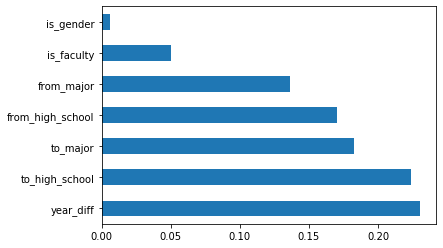

In [14]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

<Figure size 1440x1440 with 0 Axes>

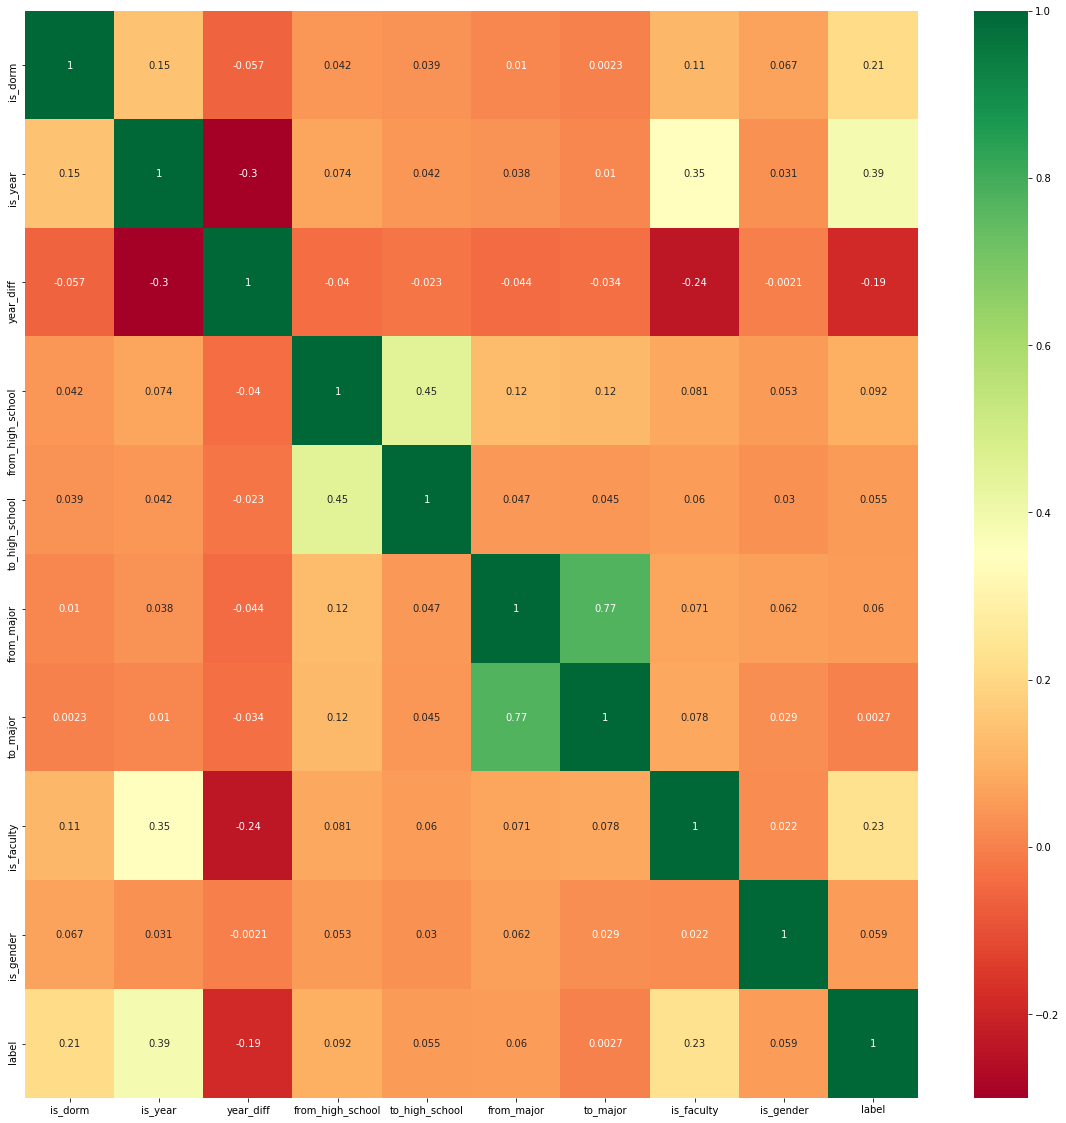

In [15]:
import seaborn as sns
X = base_df.iloc[:,2:-1]  #independent columns
y = base_df.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = base_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(base_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

<Figure size 1440x1440 with 0 Axes>

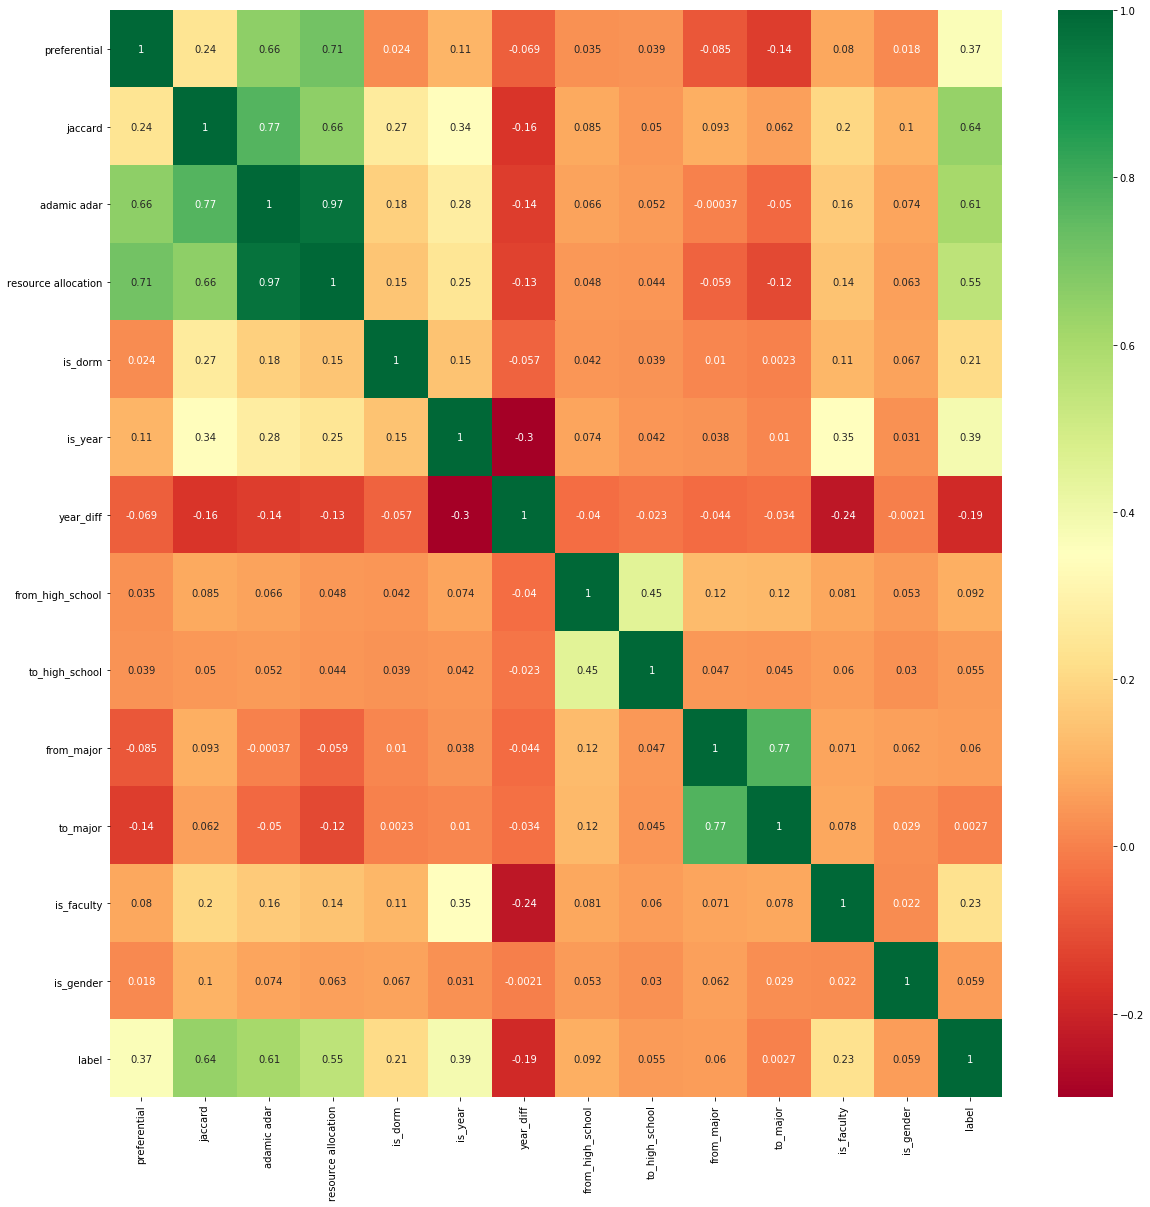

In [16]:
import seaborn as sns
X = top_df.iloc[:,:-1]  #independent columns
y = top_df.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = top_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(top_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
X = base_emb_df.iloc[:,:-1].values
y = base_emb_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , RandomForestClassifier())])
# pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [RandomForestClassifier()],
    'classifier__n_estimators' : list(range(10,101,10)),
    'classifier__max_features' : list(range(6,32,5))}
]

# Create grid search object

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)

In [ ]:
X = base_emb_df.iloc[:,:-1].values
y = base_emb_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LogisticRegression(verbose=True,max_iter=100000).fit(X_train, y_train)
yhat = model.predict(X_test)
print(confusion_matrix(y_test, yhat))

print(classification_report(y_test, yhat))
print('ROC_AUC_SCORE:',roc_auc_score(y_test, yhat))

In [ ]:
X = base_emb_df.iloc[:,:-1].drop(columns=['year_diff']).values
#print(X[:5])
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X)
X = scaler.transform(X)
y = base_emb_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LogisticRegression(verbose=True,max_iter=100000).fit(X_train, y_train)
yhat = model.predict(X_test)
print(confusion_matrix(y_test, yhat))

print(classification_report(y_test, yhat))
print('ROC_AUC_SCORE:',roc_auc_score(y_test, yhat))

In [20]:
X = base_emb_df.iloc[:,:-1].drop(columns=['year_diff']).values
#print(X[:5])
scaler = MinMaxScaler(feature_range = (0,1))

scaler.fit(X)
X = scaler.transform(X)
y = base_emb_df['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LogisticRegression(C=4.281332398719396, class_weight=None, dual=False,
                    fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                    max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                    random_state=None, solver='liblinear', tol=0.0001, verbose=1,
                    warm_start=False).fit(X_train, y_train)
yhat = model.predict(X_test)
print(confusion_matrix(y_test, yhat))

print(classification_report(y_test, yhat))
print('ROC_AUC_SCORE:',roc_auc_score(y_test, yhat))

MinMaxScaler(copy=True, feature_range=(0, 1))

[LibLinear][[7494  846]
 [1270 6888]]
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      8340
           1       0.89      0.84      0.87      8158

    accuracy                           0.87     16498
   macro avg       0.87      0.87      0.87     16498
weighted avg       0.87      0.87      0.87     16498

ROC_AUC_SCORE: 0.8714428702196371


/home/kavarakis/anaconda3/envs/link-env/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
best_clf.best_params_

In [ ]:
model = RandomForestClassifier(verbose=True).fit(X_train, y_train)
yhat = model.predict(X_test)
print(confusion_matrix(y_test, yhat))

print(classification_report(y_test, yhat))
print('ROC_AUC_SCORE:',roc_auc_score(y_test, yhat))

In [21]:
X = base_emb_df.iloc[:,:-1]
y = base_emb_df['label']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25)

In [27]:
train_data = pd.concat([X_train,y_train],axis=1)
train_data

,is_dorm,is_year,year_diff,from_high_school,to_high_school,from_major,to_major,is_faculty,is_gender,d0,...,d91,d92,d93,d94,d95,d96,d97,d98,d99,label
12084,0,0,2.598674,21605,50979,0,0,1,1,0.009043,...,-0.114566,0.103974,8.105056,0.011984,-0.811692,-0.885317,0.619827,-1.713852,-0.232280,0
8650,0,0,0.196375,3842,50509,23,23,1,0,1.169241,...,-0.203615,1.351428,1.505311,-5.385541,0.838613,-7.339266,0.083336,-0.093706,1.452046,1
8562,0,0,1.000000,0,15888,0,29,1,0,-0.061025,...,1.377803,-0.646541,-1.080458,-0.236322,-0.119946,3.093315,-1.806343,-3.883438,0.106185,0
4552,0,0,0.751263,9264,9324,237,278,1,0,-4.945562,...,-0.473786,0.162936,-0.183772,-0.010339,0.108155,2.111174,2.141166,-2.577470,-0.837337,0
3585,0,1,0.000000,17247,50365,41,41,1,1,3.073030,...,-0.251277,-1.397056,0.346301,0.769060,2.957352,6.759434,3.303279,-0.730744,1.620668,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2676,0,0,2.000000,16432,50029,244,265,1,1,-0.083751,...,11.321821,0.225317,10.362447,0.159778,2.539666,3.461574,4.230124,-3.097405,0.970182,1
18899,0,0,6.000000,3402,3697,52,60,0,0,0.538104,...,0.414345,0.019690,0.377398,-5.145967,0.056136,2.448334,-0.291162,0.921016,0.284234,0
15853,0,1,0.000000,0,17528,0,106,0,0,-0.007225,...,-0.000264,0.768562,-0.124517,0.002951,-0.071670,-0.032135,-0.045362,0.076597,-0.086622,0
90,0,0,1.000000,0,15981,0,249,0,1,6.753480,...,4.271925,1.496508,1.468187,4.981483,3.830844,2.441289,1.098988,-0.106735,4.311170,1


In [28]:
test_data = pd.concat([X_test,y_test],axis=1)
test_data

,is_dorm,is_year,year_diff,from_high_school,to_high_school,from_major,to_major,is_faculty,is_gender,d0,...,d91,d92,d93,d94,d95,d96,d97,d98,d99,label
8541,0,1,0.0000,2790,6280,17,17,1,0,1.214222,...,0.256936,0.373482,0.005021,0.007502,0.099064,0.288914,-0.321624,-0.039888,-0.078182,1
6991,0,0,1.0000,957,15857,66,87,1,0,0.796628,...,0.284777,-0.210483,-1.517244,1.824345,1.622625,1.909263,1.466807,-0.348728,2.824512,1
4512,0,0,1.8233,2041,9321,0,166,1,0,-0.911331,...,-1.443984,0.407436,0.421481,-0.171860,0.222529,-0.668052,0.575693,-0.605071,-0.185565,0
3703,0,1,0.0000,0,15996,160,195,1,0,-0.216105,...,0.634513,0.475916,-0.389908,1.375420,0.530790,2.866727,0.359445,2.800129,-0.062115,1
10667,0,0,1.0000,719,9321,0,106,0,0,-1.083071,...,1.263539,-1.203965,-0.142943,-0.294001,0.456097,0.538212,1.730083,-0.346626,-1.812186,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3222,0,0,3.0000,16396,17941,265,293,0,1,-0.936256,...,-2.325674,-1.000033,0.769276,-0.537345,0.047052,-3.437677,-0.223856,-0.601127,4.409850,1
698,0,0,1.0000,24694,50900,236,255,1,0,2.002585,...,-0.587402,0.139390,-0.281391,0.441919,0.036237,0.105551,1.452086,-0.046966,0.296312,1
2586,1,1,0.0000,5282,52701,0,280,1,1,1.216648,...,2.775038,2.231615,2.067369,2.428166,-0.022043,0.204168,2.156665,0.277167,1.506624,1
4297,0,0,4.0000,50383,51925,0,265,0,0,-5.840216,...,0.007517,0.509886,-2.850676,-0.475751,0.886216,-3.705890,0.117742,-1.526013,-0.032534,0


In [33]:
train_data.to_csv('node2vec_train.csv.gz', compression='gzip',index=False,sep='\t')

In [34]:
test_data.to_csv('node2vec_test.csv.gz', compression='gzip',index=False,sep='\t')